In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot
import time

sys.path.insert(0, '..')

from pybandstructure import *

import graphene as gr

import pybandstructure.models.twisted_bilayer as koshino

import tqdm

In [2]:
#################### graphene parameters #######################################
#distances in nm, energies in eV
a = 0.142 * np.sqrt(3) #[nm] lattice constant of graphene
theta = 1.35 #twist angle [deg]
eta = 0.01
#################### computational parameters ##################################
n_sites = 60 # number of unit cells of the crystal in one direction !must be multiple of 6!
G_max = 2 #number of shells considered in reciprocal space
G_cut_off = 2 #number of shells considered in reciprocal space for the calculation of density operator
####################### Output folder ##########################################
output_folder = 'test_output/tblg'
file_name = '/tblg.hdf5'

In [3]:
#lenght of reciprocal lattice vectors
G = 8. * np.pi * np.sin(theta / 360. * np.pi)/ (np.sqrt(3) * a)
#define reciprocal lattice basis
reciprocal_lattice_basis = G * np.array([[          0.5,         -0.5],
                                         [np.sqrt(3)/2.,np.sqrt(3)/2.]], dtype = float)

#select point group (D3 in general for TBLG, D6 if u_0 = 0) or trivial

point_group_t = Point_Group.trivial_group(space_dimension=2)

point_group_d6 = Point_Group.dihedral_group(n=6, theta0 = np.arctan2(reciprocal_lattice_basis[1,0], 
                                                     reciprocal_lattice_basis[0,0]))

point_group_d3 = Point_Group.dihedral_group(n=3, theta0 = np.arctan2(reciprocal_lattice_basis[1,0], 
                                                     reciprocal_lattice_basis[0,0]))

#defines lattice geometry given Bravais lattice 
lattice_geometry_t = Crystal_Geometry(reciprocal_lattice_basis = reciprocal_lattice_basis, 
                                    point_group = point_group_t)
lattice_geometry_d6 = Crystal_Geometry(reciprocal_lattice_basis = reciprocal_lattice_basis, 
                                    point_group= point_group_d6)
lattice_geometry_d3 = Crystal_Geometry(reciprocal_lattice_basis = reciprocal_lattice_basis, 
                                    point_group= point_group_d3)


#sampling of reciprocal lattice
reciprocal_lattice_vectors = Sample.lattice_sample(basis_vectors=reciprocal_lattice_basis, cut_off=G * G_max)

Mxy = int(n_sites/2)
Kxy = int(n_sites/3)

special_points = {'$\Gamma$': (0, 0), '$M$': (Mxy, 0), '$M^\prime$': (0, Mxy), '$K$': (Kxy, Kxy)}

k_sample = Unit_Cell_Sample.irreducible_wigner_seitz_cell(basis_vectors= reciprocal_lattice_basis, 
                                                denominator=n_sites, point_group = point_group_d3, special_points = special_points)

#k_sample = Space_Sample.spherical_sample(basis_vectors = reciprocal_lattice_basis, 
#                                         denominator = n_sites, 
#                                         cut_off = 1. )
q_sample = Unit_Cell_Sample.wigner_seitz_cell(basis_vectors= reciprocal_lattice_basis, 
                                               denominator=n_sites, special_points = special_points)

G_sample = Sample.lattice_sample(basis_vectors=reciprocal_lattice_basis, cut_off=G * G_cut_off)
ind = 500
Gind = 5

In [4]:
symmetry_repr_t = lattice_geometry_t.point_group.integer_representation(lattice_geometry_t._reciprocal_lattice_basis)

q_symmetry_repr = np.zeros([lattice_geometry_t._point_group.cardinality, len(q_sample)], dtype = int)
for g in range(lattice_geometry_t._point_group.cardinality):
    for q_ind in range(len(q_sample)):
        q_symmetry_repr[g, q_ind]= q_sample[tuple(symmetry_repr_t[g, :, :].T @ q_sample.integer_coords[q_ind])]

print(q_symmetry_repr[0,60])
print(q_sample.get_coords(60))
print(q_sample.get_coords(q_symmetry_repr[g,60]))

plt.xlim(-G * G_max,G * G_max)
plt.ylim(-G * G_max,G * G_max)
reciprocal_lattice_vectors.plot()
q_sample.plot()
for g in range(lattice_geometry_t._point_group.cardinality):
    plt.plot(*q_sample.get_coords(q_symmetry_repr[g,ind]),'^', color = 'r',ms=6)
plt.plot(*q_sample.get_coords(ind),'o', color = 'k',ms=2)
plt.title(r'Trival group')
plt.xlabel(r'$q_x\,[{\rm nm^{-1}}]$')
plt.ylabel(r'$q_y\,[{\rm nm^{-1}}]$')
plt.show()

60
[0.00579189 0.01003184]
[0.00579189 0.01003184]


../pybandstructure/sample/sample.py:551: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
../pybandstructure/sample/sample.py:551: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


In [5]:
symmetry_repr_d3 = lattice_geometry_d3.point_group.integer_representation(lattice_geometry_d3._reciprocal_lattice_basis)

q_symmetry_repr = np.zeros([lattice_geometry_d3._point_group.cardinality, len(q_sample)], dtype = int)
for g in range(lattice_geometry_d3._point_group.cardinality):
    for q_ind in range(len(q_sample)):
        q_symmetry_repr[g, q_ind]= q_sample[tuple(symmetry_repr_d3[g, :, :].T @ q_sample.integer_coords[q_ind])]

        plt.xlim(-G * G_max,G * G_max)
plt.ylim(-G * G_max,G * G_max)
reciprocal_lattice_vectors.plot()
q_sample.plot()

for g in range(lattice_geometry_d3._point_group.cardinality):
    plt.plot(*q_sample.get_coords(q_symmetry_repr[g,ind]),'^', color = 'r',ms=6)

plt.plot(*q_sample.get_coords(ind),'o', color = 'k',ms=2)
plt.title(r'Dihedral group D3')
plt.xlabel(r'$q_x\,[{\rm nm^{-1}}]$')
plt.ylabel(r'$q_y\,[{\rm nm^{-1}}]$')

../pybandstructure/sample/sample.py:551: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
../pybandstructure/sample/sample.py:551: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


Text(0, 0.5, '$q_y\\,[{\\rm nm^{-1}}]$')

In [6]:
symmetry_repr_d6 = lattice_geometry_d6.point_group.integer_representation(lattice_geometry_d6._reciprocal_lattice_basis)

q_symmetry_repr = np.zeros([lattice_geometry_d6._point_group.cardinality, len(q_sample)], dtype = int)
for g in range(lattice_geometry_d6._point_group.cardinality):
    for q_ind in range(len(q_sample)):
        q_symmetry_repr[g, q_ind]= q_sample[tuple(symmetry_repr_d6[g, :, :].T @ q_sample.integer_coords[q_ind])]
    
plt.xlim(-G * G_max,G * G_max)
plt.ylim(-G * G_max,G * G_max)
reciprocal_lattice_vectors.plot()
q_sample.plot()

for g in range(lattice_geometry_d6._point_group.cardinality):
    plt.plot(*q_sample.get_coords(q_symmetry_repr[g,ind]),'^', color = 'r',ms=6)

plt.plot(*q_sample.get_coords(ind),'o', color = 'k',ms=2)
plt.title(r'Dihedral group D6')
plt.xlabel(r'$q_x\,[{\rm nm^{-1}}]$')
plt.ylabel(r'$q_y\,[{\rm nm^{-1}}]$')

../pybandstructure/sample/sample.py:551: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
../pybandstructure/sample/sample.py:551: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


Text(0, 0.5, '$q_y\\,[{\\rm nm^{-1}}]$')

In [7]:
symmetry_repr_d6 = lattice_geometry_d6.point_group.integer_representation(lattice_geometry_d6._reciprocal_lattice_basis)

G_symmetry_repr = np.zeros([lattice_geometry_d6._point_group.cardinality, len(G_sample)], dtype = int)
for g in range(lattice_geometry_d6._point_group.cardinality):
    for G_ind in range(len(G_sample)):
        G_symmetry_repr[g, G_ind]= G_sample[tuple(symmetry_repr_d6[g, :, :].T @ G_sample.integer_coords[G_ind])]
    
plt.xlim(-G * G_max,G * G_max)
plt.ylim(-G * G_max,G * G_max)
reciprocal_lattice_vectors.plot()
G_sample.plot()

for g in range(lattice_geometry_d6._point_group.cardinality):
    plt.plot(*G_sample.get_coords(G_symmetry_repr[g,Gind]),'^', color = 'r',ms=6)

plt.plot(*G_sample.get_coords(Gind),'o', color = 'k',ms=2)
plt.title(r'Dihedral group D6')
plt.xlabel(r'$q_x\,[{\rm nm^{-1}}]$')
plt.ylabel(r'$q_y\,[{\rm nm^{-1}}]$')

../pybandstructure/sample/sample.py:551: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
../pybandstructure/sample/sample.py:551: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


Text(0, 0.5, '$q_y\\,[{\\rm nm^{-1}}]$')

In [8]:
k_plus_q_tab = np.zeros([len(q_sample),len(k_sample)], dtype = int)
for k_int in k_sample:
    for q_int in q_sample:
        k_index = k_sample[k_int]
        q_index = q_sample[q_int]
        k_plus_q_int = tsum(k_int, q_int)
        if not(k_plus_q_int in k_sample):
            print('k_plus_q_int False')
            break

In [9]:
#load band_structure if exists
#First run TBG_polarization

band_structure = Band_Structure.from_file(file_name = output_folder + file_name, band_structure_name = 'band_structure')

In [10]:
print(band_structure.density_matrix.shape)
densityG = np.nan_to_num(band_structure.density_matrix[
                    0,
                    0,
                    :,
                    q_symmetry_repr[0,2],
                    G_symmetry_repr[0,0]])

k_p_q_ind = band_structure._k_plus_q_ind[q_symmetry_repr[0,2],:]
print(densityG[330])
print(k_p_q_ind[330])
print(band_structure.energies[0, k_p_q_ind[330]])
print(band_structure.energies[0, 0])

(8, 8, 1764, 1764, 1)
(0.9363260025895161+0.1904282460339679j)
332
-0.255806458392451
-0.22862486015170524


631


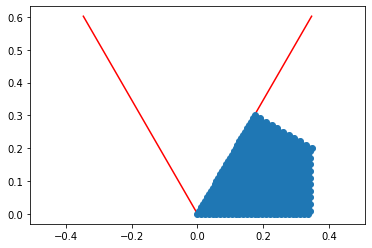

In [11]:
k_sample.plot()
print(len(k_sample))

try:
    assert(k_sample((632,0))['index'] in range(len(k_sample)))
except:
    print('NO')
